<a href="https://colab.research.google.com/github/Sanagua/PROYECTO1-SANAGUA/blob/main/PF_Abel_Sanagua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PROYECTO FINAL ABEL ALEJANDRO SANAGUA - BASE DE DATOS (RETAIL)##

Con el set de datos Retail, buscamos predecir que clientes representan fidelidad y futras compras. También busca, donde reforzar puntos débiles.

Detectar clientes que probablemente vuelvan a comprar (recurrentes).

Aplicar campañas de marketing o beneficios para fidelizar a quienes tienen menos probabilidad de volver.

Optimizar esfuerzos comerciales y segmentar mejor a los clientes.

In [ ]:
#IMPORTAR LIBREARIAS Y BASE DE DATOS - CON ENCABEZADOS
import pandas as pd
df = pd.read_excel('/content/retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France


In [ ]:
# Convertir fecha - Eliminar filas con datos faltantes clave - Calcular monto total
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df.dropna(subset=['CustomerID', 'InvoiceNo', 'Quantity', 'UnitPrice'])
df['MontoTotal'] = df['Quantity'] * df['UnitPrice']
df['CustomerID'] = df['CustomerID'].astype(int)

/tmp/ipython-input-2-2149831607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MontoTotal'] = df['Quantity'] * df['UnitPrice']
/tmp/ipython-input-2-2149831607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)


Categorizamos con una columna binaria al cliente recurrente

In [ ]:
# Número de facturas por cliente
facturas_por_cliente = df[['InvoiceNo', 'CustomerID']].drop_duplicates()
frecuencia_cliente = facturas_por_cliente['CustomerID'].value_counts()

# Si tiene más de 1 factura → recurrente
clientes_recurrentes = frecuencia_cliente[frecuencia_cliente > 1].index
df['cliente_recurrente'] = df['CustomerID'].apply(lambda x: 1 if x in clientes_recurrentes else 0)

CantidadTotal: total de unidades compradas en esa factura

MontoTotal: total facturado en esa factura

StockCode nunique: cuántos productos diferentes compró → ProductosUnicos

In [ ]:
# Características por factura
agg_df = df.groupby(['InvoiceNo', 'CustomerID', 'Country']).agg({
    'Quantity': 'sum',
    'MontoTotal': 'sum',
    'StockCode': 'nunique'
}).reset_index()

agg_df.rename(columns={
    'Quantity': 'CantidadTotal',
    'MontoTotal': 'MontoFactura',
    'StockCode': 'ProductosUnicos'
}, inplace=True)

# Etiqueta target
agg_df = agg_df.merge(df[['InvoiceNo', 'CustomerID', 'cliente_recurrente']].drop_duplicates(), on=['InvoiceNo', 'CustomerID'])

Agregamos un código único por país - para usarlo como entrada al modelo de clasificación.

CantidadTotal: total de unidades compradas

MontoFactura: monto total gastado

ProductosUnicos: variedad de productos

PaisCodificado: país del cliente como número

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar país
le = LabelEncoder()
agg_df['PaisCodificado'] = le.fit_transform(agg_df['Country'])

# Seleccionar features y target
X = agg_df[['CantidadTotal', 'MontoFactura', 'ProductosUnicos', 'PaisCodificado']]
y = agg_df['cliente_recurrente']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo rápido
modelo = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
modelo.fit(X_train, y_train)

# Predicción
y_pred = modelo.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0  272]
 [   0 3564]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.93      1.00      0.96      3564

    accuracy                           0.93      3836
   macro avg       0.46      0.50      0.48      3836
weighted avg       0.86      0.93      0.89      3836



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Entrené un modelo Random Forest para predecir si una factura pertenece a un cliente recurrente o no. El modelo alcanzó un 93% de accuracy, pero al analizar más a fondo descubrí va dirigido hacia la clase mayoritaria recurrentes.

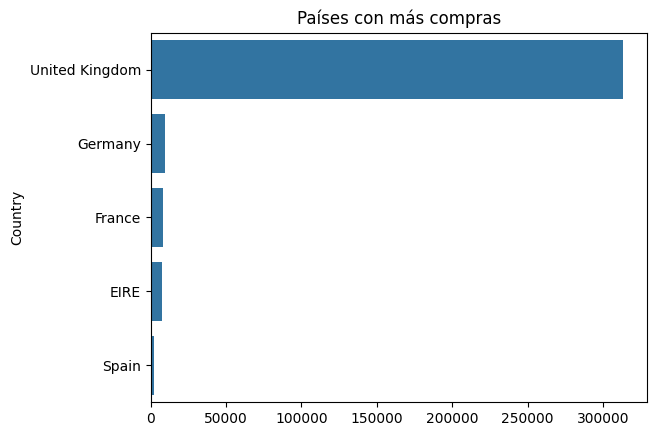

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_paises = df['Country'].value_counts().head(5)
sns.barplot(x=top_paises.values, y=top_paises.index)
plt.title("Países con más compras")
plt.show()

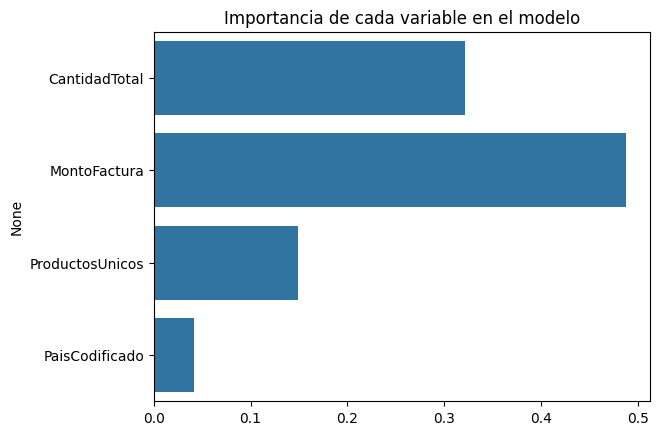

In [ ]:
importances = modelo.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importancia de cada variable en el modelo")
plt.show()

El modelo muestra que el MontoFactura es el predictor más fuerte de recurrencia, lo cual es coherente: los clientes que gastan más tienden a volver.

 Creamos una nueva columna llamada cliente_recurrente:

1- si ese cliente es recurrente

0- si solo compró una vez

In [ ]:
# Contar facturas por cliente
facturas_unicas = df[['InvoiceNo', 'CustomerID']].drop_duplicates()
frecuencia_clientes = facturas_unicas['CustomerID'].value_counts()

# Definir recurrentes (más de 1 factura)
recurrentes = frecuencia_clientes[frecuencia_clientes > 1].index
df['cliente_recurrente'] = df['CustomerID'].apply(lambda x: 1 if x in recurrentes else 0)

Claramente se puede observar en el gráfico que United Kingdom es nuestro mas grande cliente

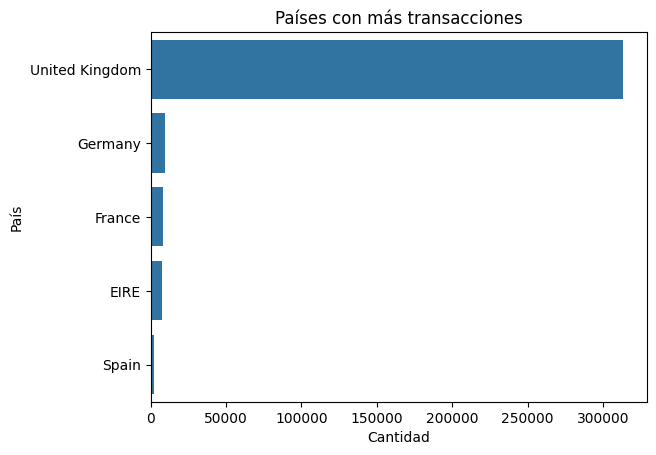

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 5 países
top_paises = df['Country'].value_counts().head(5)

sns.barplot(x=top_paises.values, y=top_paises.index)
plt.title("Países con más transacciones")
plt.xlabel("Cantidad")
plt.ylabel("País")
plt.show()

In [ ]:
# Agrupar por factura
agg_df = df.groupby(['InvoiceNo', 'CustomerID', 'Country']).agg({
    'Quantity': 'sum',
    'MontoTotal': 'sum',
    'StockCode': 'nunique'
}).reset_index()

agg_df.rename(columns={
    'Quantity': 'CantidadTotal',
    'MontoTotal': 'MontoFactura',
    'StockCode': 'ProductosUnicos'
}, inplace=True)

agg_df = agg_df.merge(df[['InvoiceNo', 'CustomerID', 'cliente_recurrente']].drop_duplicates(), on=['InvoiceNo', 'CustomerID'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar país
le = LabelEncoder()
agg_df['PaisCodificado'] = le.fit_transform(agg_df['Country'])

# Variables y target
X = agg_df[['CantidadTotal', 'MontoFactura', 'ProductosUnicos', 'PaisCodificado']]
y = agg_df['cliente_recurrente']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo rápido y eficiente
modelo = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
modelo.fit(X_train, y_train)

# Predicción
y_pred = modelo.predict(X_test)

# Evaluación
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Matriz de confusión:
 [[   0  272]
 [   0 3564]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.93      1.00      0.96      3564

    accuracy                           0.93      3836
   macro avg       0.46      0.50      0.48      3836
weighted avg       0.86      0.93      0.89      3836



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Distribución de clases
y.value_counts().sort_index()

,count
cliente_recurrente,
0,1336
1,17843


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')      # salida binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

La primera capa oculta tiene 16 neuronas con activación ReLU, que captura relaciones no lineales.

La segunda capa tiene 8 neuronas, ayudando a refinar la representación.

La capa final con 1 neurona y activación sigmoide es adecuada para clasificación binaria, prediciendo la probabilidad de que un cliente sea recurrente.

In [ ]:
X_train_small = X_train_scaled[:2000]
y_train_small = y_train[:2000]

Se entrenó un modelo de red neuronal sencillo con dos capas ocultas pequeñas y pocas épocas para acelerar el proceso. Esta configuración permite obtener un modelo funcional en poco tiempo. El modelo optimiza la función de pérdida binaria y monitorea la precisión durante entrenamiento y validación.

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),  # menos neuronas
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=5,           # menos épocas
    batch_size=32
)


Epoch 1/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8201 - loss: 0.5665 - val_accuracy: 0.9304 - val_loss: 0.2549
Epoch 2/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9283 - loss: 0.2586 - val_accuracy: 0.9304 - val_loss: 0.2502
Epoch 3/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9297 - loss: 0.2520 - val_accuracy: 0.9304 - val_loss: 0.2497
Epoch 4/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9293 - loss: 0.2521 - val_accuracy: 0.9304 - val_loss: 0.2493
Epoch 5/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9340 - loss: 0.2394 - val_accuracy: 0.9304 - val_loss: 0.2491


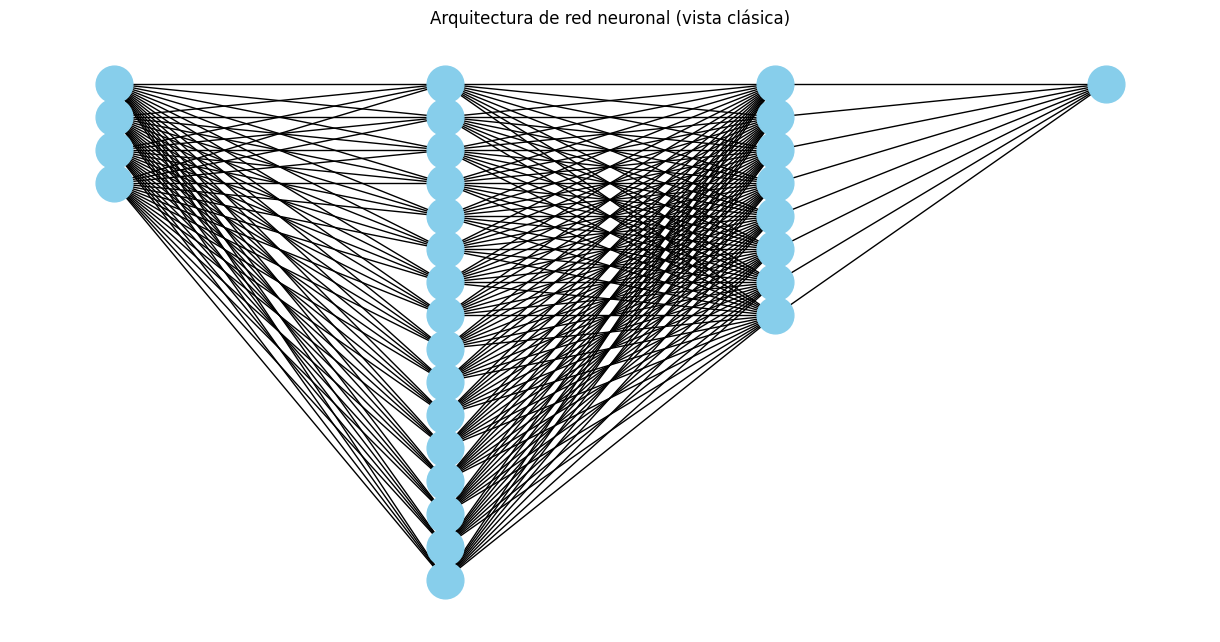

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def dibujar_red(neuronas_por_capa):
    G = nx.DiGraph()
    pos = {}

    for capa_idx, num_neuronas in enumerate(neuronas_por_capa):
        for n in range(num_neuronas):
            node_id = f"C{capa_idx}_N{n}"
            G.add_node(node_id)
            # Posición: capa en X, neurona en Y (invertida para que la 0 esté arriba)
            pos[node_id] = (capa_idx, -n)

            # Conectar con capa anterior
            if capa_idx > 0:
                for prev_n in range(neuronas_por_capa[capa_idx - 1]):
                    prev_id = f"C{capa_idx - 1}_N{prev_n}"
                    G.add_edge(prev_id, node_id)

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=700, node_color='skyblue')
    plt.title("Arquitectura de red neuronal (vista clásica)")
    plt.axis('off')
    plt.show()

# Definimos la arquitectura:
# Entrada: 4 features
# Capa oculta 1: 16 neuronas
# Capa oculta 2: 8 neuronas
# Salida: 1 neurona (binaria)

dibujar_red([4, 16, 8, 1])

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train,               # etiquetas sin one-hot para salida sigmoid
    epochs=5,              # menos épocas
    batch_size=32,         # batch razonable para velocidad y estabilidad
    validation_split=0.2,  # separa 20% de train para validación
    verbose=1
)


Epoch 1/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9321 - loss: 0.2438 - val_accuracy: 0.9283 - val_loss: 0.2542
Epoch 2/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9336 - loss: 0.2397 - val_accuracy: 0.9283 - val_loss: 0.2539
Epoch 3/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9290 - loss: 0.2511 - val_accuracy: 0.9283 - val_loss: 0.2539
Epoch 4/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9285 - loss: 0.2539 - val_accuracy: 0.9283 - val_loss: 0.2539
Epoch 5/5
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9296 - loss: 0.2512 - val_accuracy: 0.9283 - val_loss: 0.2541


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Predecir probabilidades de clase 1
y_pred_probs = model.predict(X_test_scaled)

# Convertir probabilidades a etiquetas 0/1 con umbral 0.5
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Reporte de clasificación
print(classification_report(y_test, y_pred))


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       267
           1       0.93      1.00      0.96      3569

    accuracy                           0.93      3836
   macro avg       0.47      0.50      0.48      3836
weighted avg       0.87      0.93      0.90      3836



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


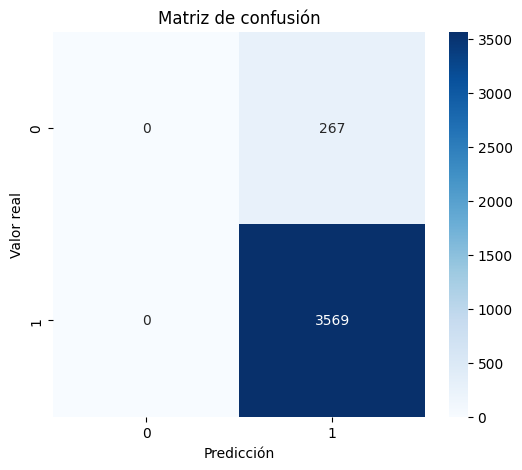

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show()

#CONCLUSIÓN#

El modelo principal utilizado fue un Random Forest CLASIFICACIÓN, el cual se seleccionó por la capacidad para manejar datos con relaciones no lineales. Inicialmente, el modelo mostró un alto nivel de precisión general (93%), aunque este valor estuvo influenciado por un fuerte desbalance de clases (93% de los clientes eran recurrentes).

Este trabajo demuestra cómo, a partir de simples datos de transacciones, es posible generar modelos predictivos que puedan ayudar a una empresa a anticipar el comportamiento de sus clientes, optimizar sus campañas de fidelización y tomar decisiones estratégicas basadas en datos.

In [ ]:
print(" Predicciones (probabilidades sigmoid) - primeras 5 instancias:")
print(np.round(y_pred_probs[:5].flatten(), 3))

print("\n Las probabilidades están entre 0 y 1 (no suman a 1 porque es binaria):")
print(f"Min: {np.min(y_pred_probs[:5]):.3f}, Max: {np.max(y_pred_probs[:5]):.3f}")


 Predicciones (probabilidades sigmoid) - primeras 5 instancias:
[0.905 0.948 0.912 0.91  0.949]

 Las probabilidades están entre 0 y 1 (no suman a 1 porque es binaria):
Min: 0.905, Max: 0.949


In [ ]:
# Etiquetas predichas con umbral 0.5
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

print("\n Predicciones vs Etiquetas reales (primeras 5):")
for i in range(5):
    print(f"Instancia {i+1}: Probabilidad={y_pred_probs[i][0]:.3f}, Predicción={y_pred_labels[i]}, Real={y_test.iloc[i]}")


 Predicciones vs Etiquetas reales (primeras 5):
Instancia 1: Probabilidad=0.905, Predicción=1, Real=1
Instancia 2: Probabilidad=0.948, Predicción=1, Real=1
Instancia 3: Probabilidad=0.912, Predicción=1, Real=1
Instancia 4: Probabilidad=0.910, Predicción=1, Real=1
Instancia 5: Probabilidad=0.949, Predicción=1, Real=1


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_labels)
print("\n Matriz de confusión (números):")
print(cm)


 Matriz de confusión (números):
[[   0  267]
 [   0 3569]]


La curva Precision-Recall evidencia que el modelo presenta dificultades para mantener un buen equilibrio entre precisión y recall a medida que se intenta capturar un mayor porcentaje de clientes recurrentes. Esto sugiere que, aunque el modelo puede identificar con alta confianza algunos clientes recurrentes, su capacidad para generalizar a casos más diversos es limitada.

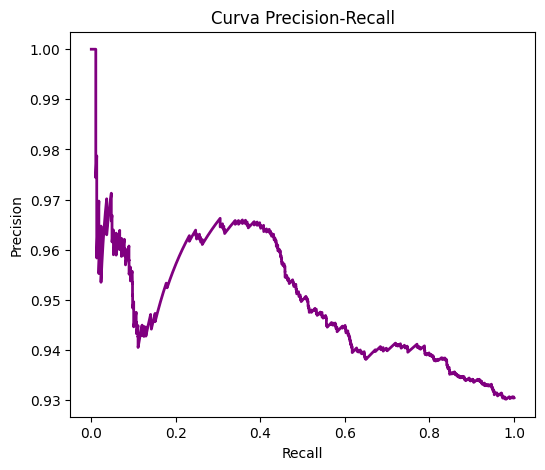

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.show()

El histograma muestra la distribución de las probabilidades que el modelo asigna a cada clase (cliente recurrente o no). Se observa que para la clase 1 (clientes recurrentes) las probabilidades predichas se concentran mayormente en valores altos, cercanos a 0.92-0.93, lo que indica que el modelo es bastante seguro al identificar a estos clientes.

Por otro lado, la clase 0 (clientes no recurrentes) también presenta una concentración en un rango similar, aunque ligeramente más dispersa. Esto sugiere que el modelo puede tener dificultades para diferenciar claramente entre ambas clases en ciertos casos, produciendo predicciones con probabilidades cercanas para ambos grupos.

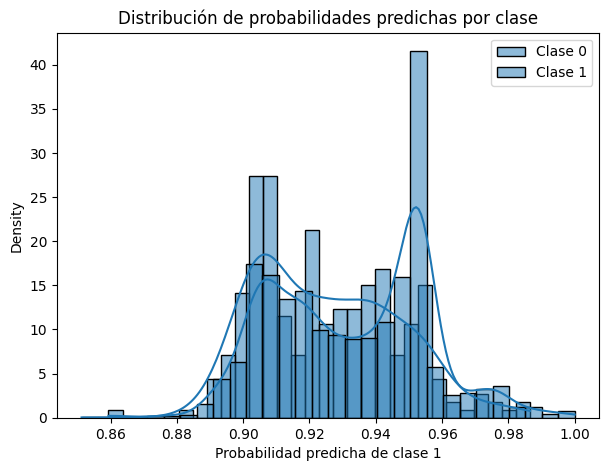

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(y_pred_probs[y_test == 0], color='blue', label='Clase 0', kde=True, stat="density", bins=30)
sns.histplot(y_pred_probs[y_test == 1], color='orange', label='Clase 1', kde=True, stat="density", bins=30)
plt.title("Distribución de probabilidades predichas por clase")
plt.xlabel("Probabilidad predicha de clase 1")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df['MontoFactura'] = df['Quantity'] * df['UnitPrice']

In [ ]:
compras_por_cliente = df.groupby('CustomerID')['InvoiceNo'].nunique()
clientes_recurrentes = compras_por_cliente[compras_por_cliente > 1].index

df['ClienteRecurrente'] = df['CustomerID'].apply(lambda x: 1 if x in clientes_recurrentes else 0)


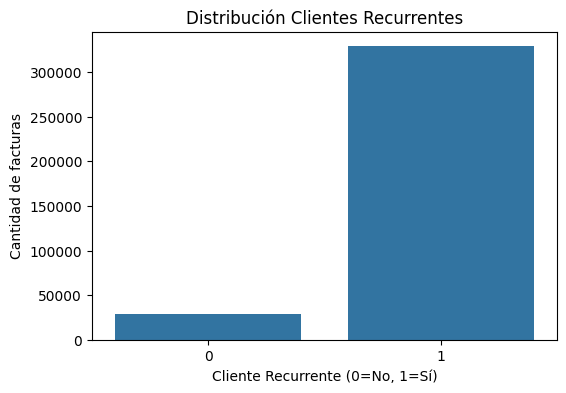

In [ ]:
# Crear variable ClienteRecurrente
compras_por_cliente = df.groupby('CustomerID')['InvoiceNo'].nunique()
clientes_recurrentes = compras_por_cliente[compras_por_cliente > 1].index
df['ClienteRecurrente'] = df['CustomerID'].apply(lambda x: 1 if x in clientes_recurrentes else 0)
plt.figure(figsize=(6,4))
sns.countplot(x='ClienteRecurrente', data=df)
plt.title("Distribución Clientes Recurrentes")
plt.xlabel("Cliente Recurrente (0=No, 1=Sí)")
plt.ylabel("Cantidad de facturas")
plt.show()


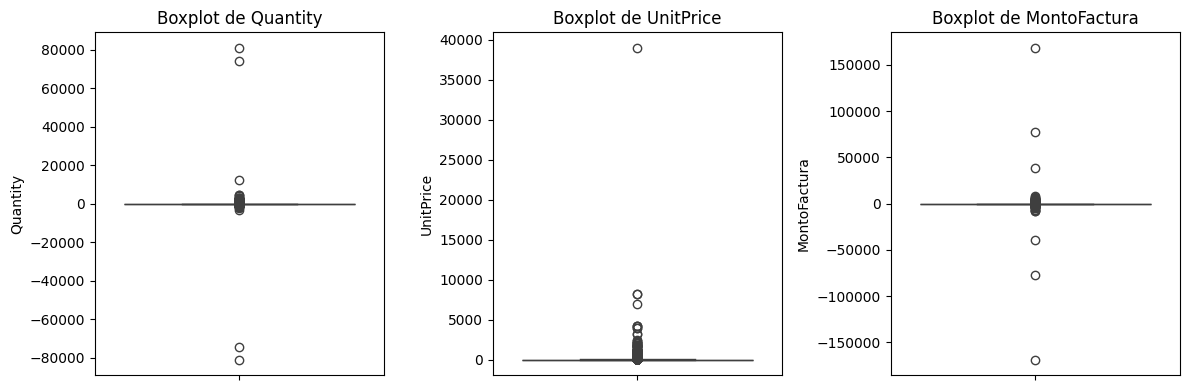

In [ ]:
plt.figure(figsize=(12,4))
for i, col in enumerate(['Quantity', 'UnitPrice', 'MontoFactura']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

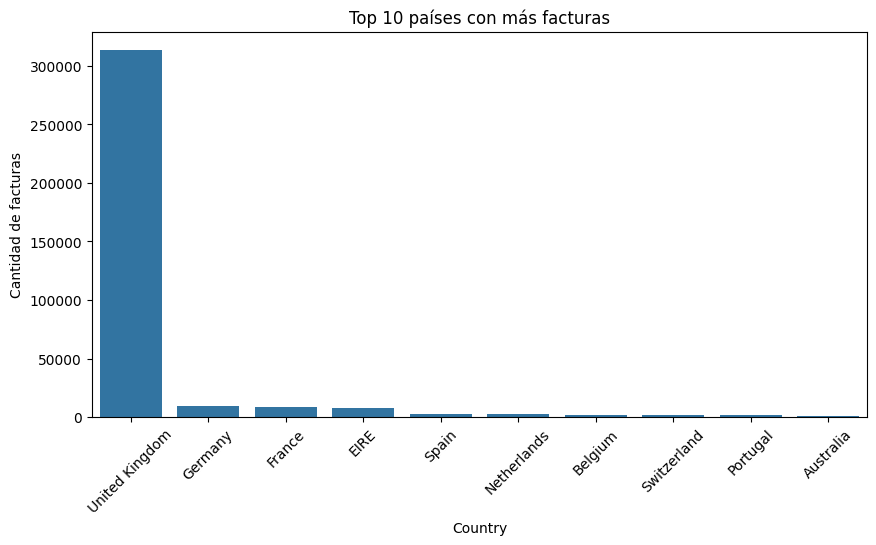

In [ ]:
# Top 10 países por cantidad de facturas
top_countries = df['Country'].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title("Top 10 países con más facturas")
plt.ylabel("Cantidad de facturas")
plt.show()

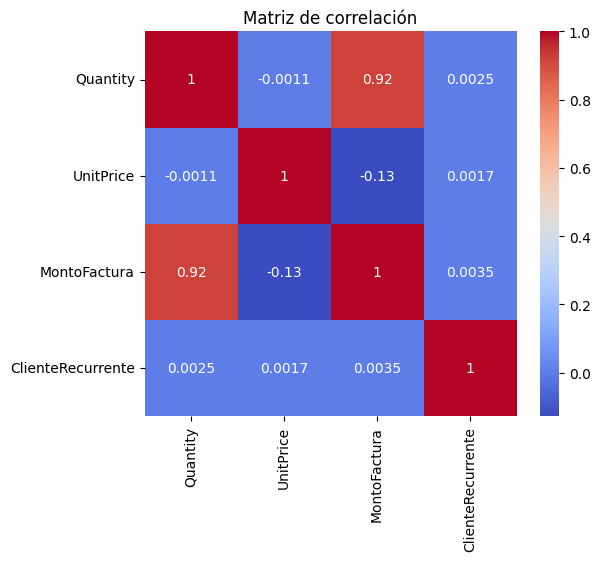

In [ ]:
corr = df[['Quantity', 'UnitPrice', 'MontoFactura', 'ClienteRecurrente']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()